In [11]:
import os, json, matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -----------------
# Dataset setup
# -----------------
max_features = 10000   # vocabulary size
maxlen = 200           # max words per review

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# pad sequences to fixed length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test  = pad_sequences(X_test,  maxlen=maxlen)

vocab_size = max_features  # used in embedding layers

# output folders
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)


In [12]:
def build_lstm(vocab_size):
    model = Sequential([
        Embedding(vocab_size, 128),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_gru(vocab_size):
    model = Sequential([
        Embedding(vocab_size, 128),
        GRU(64),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_bilstm(vocab_size):
    model = Sequential([
        Embedding(vocab_size, 128),
        Bidirectional(LSTM(64)),
        Dense(1, activation='sigmoid')
    ])
    return model


In [17]:
def plot_history(history_dict, title, outpath):
    plt.figure()
    plt.plot(history_dict['accuracy'], label='train')
    plt.plot(history_dict['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.close()

def train_and_save(name, model):
    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    # Early stopping (longer patience so we can reach 15 epochs if improving)
    es = EarlyStopping(
        patience=15,                 # allow full 15 epochs if validation keeps improving
        monitor='val_accuracy',
        restore_best_weights=True
    )

    # Train for up to 15 epochs
    h = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=15,
        batch_size=64,
        verbose=2,
        callbacks=[es]
    )

    # Save model + training history
    model.save(f"models/imdb_{name}.h5")
    with open(f"models/imdb_{name}_history.json", "w") as f:
        json.dump(h.history, f)

    # Plot accuracy curves
    plot_history(
        h.history,
        f"IMDB {name.upper()} Accuracy",
        f"figures/Fig3_imdb_curves_{name}.png"
    )

    # Evaluate & confusion matrix
    y_prob = model.predict(X_test, verbose=0)
    y_pred = (y_prob > 0.5).astype("int32").reshape(-1)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot()
    plt.title(f"Confusion Matrix – {name.upper()} (IMDB)")
    plt.tight_layout()
    plt.savefig(f"figures/Fig5_confusion_imdb_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Metrics
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred,
        average='binary',
        zero_division=0
    )
    acc = (y_pred == y_test).mean()

    return {
        "model": name.upper(),
        "acc": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1)
    }


In [18]:
res = []
res.append(train_and_save("lstm",   build_lstm(vocab_size)))
res.append(train_and_save("gru",    build_gru(vocab_size)))
res.append(train_and_save("bilstm", build_bilstm(vocab_size)))

# Save metrics to CSV and display
df = pd.DataFrame(res)
df.to_csv("imdb_metrics.csv", index=False)
df


Epoch 1/15
313/313 - 75s - 239ms/step - accuracy: 0.7871 - loss: 0.4439 - val_accuracy: 0.8606 - val_loss: 0.3334
Epoch 2/15
313/313 - 67s - 216ms/step - accuracy: 0.9021 - loss: 0.2485 - val_accuracy: 0.8708 - val_loss: 0.3562
Epoch 3/15
313/313 - 69s - 219ms/step - accuracy: 0.9311 - loss: 0.1815 - val_accuracy: 0.8716 - val_loss: 0.3468
Epoch 4/15
313/313 - 72s - 230ms/step - accuracy: 0.9492 - loss: 0.1428 - val_accuracy: 0.8568 - val_loss: 0.3916
Epoch 5/15
313/313 - 73s - 233ms/step - accuracy: 0.9634 - loss: 0.1038 - val_accuracy: 0.8570 - val_loss: 0.4611
Epoch 6/15
313/313 - 81s - 260ms/step - accuracy: 0.9722 - loss: 0.0821 - val_accuracy: 0.8622 - val_loss: 0.5064
Epoch 7/15
313/313 - 72s - 232ms/step - accuracy: 0.9822 - loss: 0.0544 - val_accuracy: 0.8428 - val_loss: 0.6884
Epoch 8/15
313/313 - 69s - 220ms/step - accuracy: 0.9819 - loss: 0.0548 - val_accuracy: 0.8570 - val_loss: 0.5572
Epoch 9/15
313/313 - 68s - 218ms/step - accuracy: 0.9882 - loss: 0.0395 - val_accuracy: 

Epoch 1/15
313/313 - 75s - 241ms/step - accuracy: 0.7620 - loss: 0.4727 - val_accuracy: 0.8366 - val_loss: 0.3658
Epoch 2/15
313/313 - 67s - 213ms/step - accuracy: 0.8964 - loss: 0.2650 - val_accuracy: 0.8516 - val_loss: 0.3417
Epoch 3/15
313/313 - 69s - 219ms/step - accuracy: 0.9316 - loss: 0.1831 - val_accuracy: 0.8498 - val_loss: 0.3738
Epoch 4/15
313/313 - 68s - 217ms/step - accuracy: 0.9488 - loss: 0.1409 - val_accuracy: 0.8676 - val_loss: 0.3978
Epoch 5/15
313/313 - 68s - 217ms/step - accuracy: 0.9693 - loss: 0.0892 - val_accuracy: 0.8560 - val_loss: 0.4242
Epoch 6/15
313/313 - 72s - 228ms/step - accuracy: 0.9793 - loss: 0.0636 - val_accuracy: 0.8514 - val_loss: 0.5022
Epoch 7/15
313/313 - 68s - 217ms/step - accuracy: 0.9896 - loss: 0.0355 - val_accuracy: 0.8452 - val_loss: 0.5996
Epoch 8/15
313/313 - 69s - 222ms/step - accuracy: 0.9807 - loss: 0.0562 - val_accuracy: 0.8610 - val_loss: 0.5856
Epoch 9/15
313/313 - 68s - 217ms/step - accuracy: 0.9951 - loss: 0.0186 - val_accuracy: 

Epoch 1/15
313/313 - 116s - 369ms/step - accuracy: 0.7628 - loss: 0.4718 - val_accuracy: 0.8530 - val_loss: 0.3525
Epoch 2/15
313/313 - 101s - 323ms/step - accuracy: 0.8953 - loss: 0.2618 - val_accuracy: 0.8566 - val_loss: 0.3554
Epoch 3/15
313/313 - 103s - 329ms/step - accuracy: 0.9307 - loss: 0.1850 - val_accuracy: 0.8738 - val_loss: 0.3549
Epoch 4/15
313/313 - 105s - 334ms/step - accuracy: 0.9473 - loss: 0.1421 - val_accuracy: 0.8518 - val_loss: 0.3567
Epoch 5/15
313/313 - 102s - 327ms/step - accuracy: 0.9314 - loss: 0.1733 - val_accuracy: 0.8542 - val_loss: 0.3684
Epoch 6/15
313/313 - 105s - 337ms/step - accuracy: 0.9703 - loss: 0.0892 - val_accuracy: 0.8686 - val_loss: 0.4252
Epoch 7/15
313/313 - 106s - 340ms/step - accuracy: 0.9785 - loss: 0.0615 - val_accuracy: 0.8428 - val_loss: 0.4754
Epoch 8/15
313/313 - 107s - 342ms/step - accuracy: 0.9811 - loss: 0.0567 - val_accuracy: 0.8644 - val_loss: 0.5722
Epoch 9/15
313/313 - 104s - 332ms/step - accuracy: 0.9888 - loss: 0.0365 - val_a

,model,acc,precision,recall,f1
0,LSTM,0.86132,0.861754,0.86072,0.861237
1,GRU,0.86120,0.839985,0.89240,0.865400
2,BILSTM,0.85936,0.904758,0.80328,0.851004


,model,acc,precision,recall,f1
0,LSTM,0.86132,0.861754,0.86072,0.861237
1,GRU,0.86120,0.839985,0.89240,0.865400
2,BILSTM,0.85936,0.904758,0.80328,0.851004


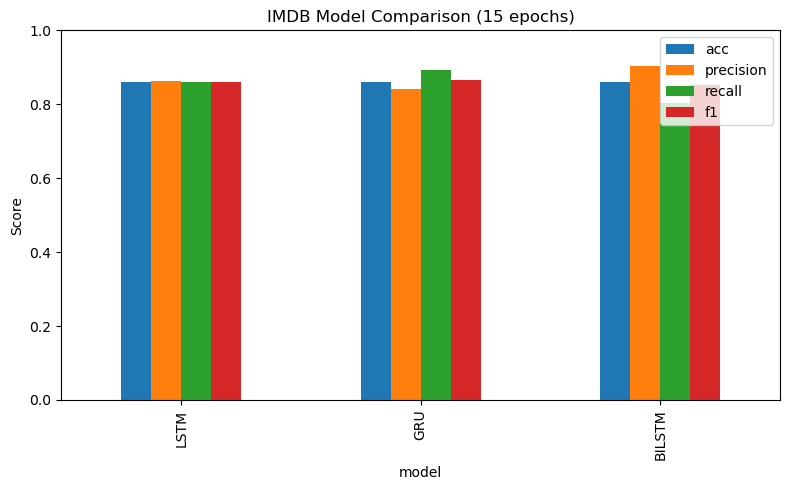


Saved figures:
 - figures\Fig3_imdb_curves_bilstm.png
 - figures\Fig3_imdb_curves_gru.png
 - figures\Fig3_imdb_curves_lstm.png
 - figures\Fig5_confusion_imdb_bilstm.png
 - figures\Fig5_confusion_imdb_gru.png
 - figures\Fig5_confusion_imdb_lstm.png

Saved models:
 - models\imdb_bilstm.h5
 - models\imdb_gru.h5
 - models\imdb_lstm.h5


In [19]:
# === Display & visualize results ===
import pandas as pd
import matplotlib.pyplot as plt
import glob, os

# If you already have `df` from the previous cell, this will just show it.
# If you re-opened the notebook, uncomment the next line to load from CSV:
# df = pd.read_csv("imdb_metrics.csv")

# 1) Show metrics table
display(df)  # Jupyter pretty table

# 2) Bar chart for all metrics
ax = df.plot(x="model", y=["acc","precision","recall","f1"], kind="bar", figsize=(8,5))
plt.ylabel("Score")
plt.title("IMDB Model Comparison (15 epochs)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# 3) List saved figures (training curves & confusion matrices)
print("\nSaved figures:")
for p in sorted(glob.glob(os.path.join("figures", "*.png"))):
    print(" -", p)

print("\nSaved models:")
for p in sorted(glob.glob(os.path.join("models", "imdb_*.h5"))):
    print(" -", p)


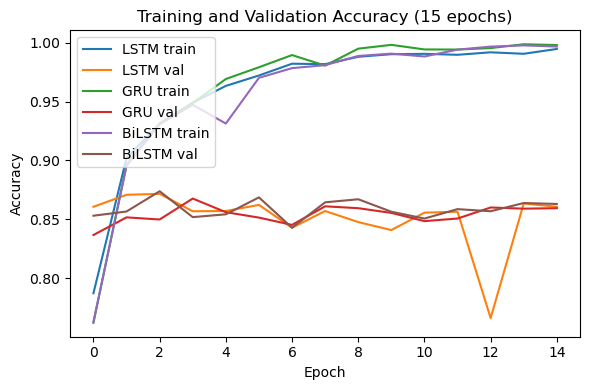

In [3]:
import json
import matplotlib.pyplot as plt

# Load the saved histories
with open("models/imdb_lstm_history.json") as f:
    lstm_hist = json.load(f)
with open("models/imdb_gru_history.json") as f:
    gru_hist = json.load(f)
with open("models/imdb_bilstm_history.json") as f:
    bilstm_hist = json.load(f)

# Plot training & validation accuracy
plt.figure(figsize=(6,4))
plt.plot(lstm_hist['accuracy'],     label='LSTM train')
plt.plot(lstm_hist['val_accuracy'], label='LSTM val')
plt.plot(gru_hist['accuracy'],      label='GRU train')
plt.plot(gru_hist['val_accuracy'],  label='GRU val')
plt.plot(bilstm_hist['accuracy'],   label='BiLSTM train')
plt.plot(bilstm_hist['val_accuracy'],label='BiLSTM val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (15 epochs)')
plt.legend()
plt.tight_layout()
plt.savefig('figures/Fig2_training_validation_curves.png', dpi=300)
plt.show()

